In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw

# 01. 데이터 확인

In [2]:
feature = pd.read_table("../feature.txt", sep=' ')
feature

,FilePath,OF_d04,OF_d05,OF_d06,OF_d07,OF_d08,OF_d09,OF_d10,OF_d11,OF_d12,...,OF_d23,OF_d24,OF_d25,OF_d26,OF_d27,WhichEye,Yaw,Pitch,X,Y
0,p00/day01/0005.jpg,594,366,637,365,719,366,762,368,626,...,23.422692,524.537075,11.040978,166.869249,-27.728178,1,0.023244,-0.263194,476,758
1,p00/day01/0030.jpg,516,394,558,392,641,387,691,384,557,...,35.034721,477.888383,-123.405644,153.787666,-16.911922,0,0.213553,-0.235904,1078,693
2,p00/day01/0031.jpg,606,375,656,379,740,385,784,389,642,...,31.445826,478.976511,88.833604,130.231245,-32.639103,0,-0.158217,-0.196739,126,598
3,p00/day01/0038.jpg,594,414,642,411,723,409,768,409,639,...,46.413972,503.507272,68.867316,12.105732,-27.491372,1,0.111116,-0.026407,211,69
4,p00/day01/0063.jpg,547,370,587,366,666,360,710,357,587,...,22.173310,535.283755,-78.668260,166.500859,-20.765887,1,-0.147365,-0.252338,878,752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37662,p14/day07/0196.jpg,636,292,693,291,787,287,846,281,675,...,-10.580621,452.969811,-45.378412,2.461243,73.521260,0,0.101574,-0.004423,730,138
37663,p14/day07/0197.jpg,627,295,698,300,777,292,844,276,686,...,-10.453849,460.352050,-92.369714,133.980553,85.550006,0,0.216397,-0.240782,963,803
37664,p14/day07/0198.jpg,632,300,689,298,783,293,841,287,673,...,-9.704783,439.385058,-166.894865,132.738778,91.855893,0,0.348198,-0.230965,1339,801
37665,p14/day07/0199.jpg,631,295,690,293,784,288,844,282,674,...,-10.911425,433.764519,-170.592286,-8.092277,83.600778,0,0.336188,0.029259,1362,92


In [15]:
print("Yaw: ", feature[["Yaw"]].min().values[0], ' ~ ', feature[["Yaw"]].max().values[0])

Yaw:  -0.5277748542522531  ~  0.7064996464845319


In [3]:
root = "../../_data/MPIIFaceGaze/"
path_people = [root+path for path in os.listdir(root) if os.path.isdir(root+path)]
path_people

['../../_data/MPIIFaceGaze/p00',
 '../../_data/MPIIFaceGaze/p01',
 '../../_data/MPIIFaceGaze/p02',
 '../../_data/MPIIFaceGaze/p03',
 '../../_data/MPIIFaceGaze/p04',
 '../../_data/MPIIFaceGaze/p05',
 '../../_data/MPIIFaceGaze/p06',
 '../../_data/MPIIFaceGaze/p07',
 '../../_data/MPIIFaceGaze/p08',
 '../../_data/MPIIFaceGaze/p09',
 '../../_data/MPIIFaceGaze/p10',
 '../../_data/MPIIFaceGaze/p11',
 '../../_data/MPIIFaceGaze/p12',
 '../../_data/MPIIFaceGaze/p13',
 '../../_data/MPIIFaceGaze/p14']

# 02. 수식으로 yaw, pitch → x, y 변환하기
참고: https://stackoverflow.com/questions/16658529/pitch-and-yaw-to-2d-screen-coords

w, h를 pixel로 설정<br>
horiz_angle_of_view = 180, MAE

In [82]:
horiz_angle_of_view = 180
vert_angle_of_view = []
K = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_pixel"][0][0]
    h = contents["height_pixel"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])

    
x_error = 0.0
y_error = 0.0

for i in range(len(feature)):
    pnum = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[pnum] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[pnum] * (pitch + 0.5 * vert_angle_of_view[pnum])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    # MAE
    x_error += abs(gt_x - X)
    y_error += abs(gt_y - Y)
    
    # MSE
    #x_error += (gt_x - X) ** 2
    #y_error += (gt_y - Y) ** 2

print("X error: ", x_error/len(feature))
print("Y error: ", y_error/len(feature))

X error:  352.29973641357947
Y error:  219.64537725766272


w, h를 실측 길이로 설정<br>
horiz_angle_of_view = 180, MAE

In [6]:
horiz_angle_of_view = 180
vert_angle_of_view = []
K = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_mm"][0][0]
    h = contents["height_mm"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])

    
x_error = 0.0
y_error = 0.0

for i in range(len(feature)):
    pnum = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[pnum] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[pnum] * (pitch + 0.5 * vert_angle_of_view[pnum])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    # MAE
    x_error += abs(gt_x - X)
    y_error += abs(gt_y - Y)
    
    # MSE
    #x_error += (gt_x - X) ** 2
    #y_error += (gt_y - Y) ** 2

print("X error: ", x_error/len(feature))
print("Y error: ", y_error/len(feature))

X error:  571.7660634194217
Y error:  356.26305887808434


horiz_angle_of_view = 180, MSE

In [7]:
horiz_angle_of_view = 180
vert_angle_of_view = []
K = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_pixel"][0][0]
    h = contents["height_pixel"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])

    
x_error = 0.0
y_error = 0.0

for i in range(len(feature)):
    pnum = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[pnum] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[pnum] * (pitch + 0.5 * vert_angle_of_view[pnum])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    # MAE
    #x_error += abs(gt_x - X)
    #y_error += abs(gt_y - Y)
    
    # MSE
    x_error += (gt_x - X) ** 2
    y_error += (gt_y - Y) ** 2

print("X error: ", x_error/len(feature))
print("Y error: ", y_error/len(feature))

X error:  167764.83975133032
Y error:  64909.78522770277


horiz_angle_of_view = 20, MAE

In [84]:
horiz_angle_of_view = 20
vert_angle_of_view = []
K = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_pixel"][0][0]
    h = contents["height_pixel"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])


x_error = 0.0
y_error = 0.0

for i in range(len(feature)):
    pnum = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[pnum] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[pnum] * (pitch + 0.5 * vert_angle_of_view[pnum])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    # MAE
    x_error += abs(gt_x - X)
    y_error += abs(gt_y - Y)
    
    # MSE
    #x_error += (gt_x - X) ** 2
    #y_error += (gt_y - Y) ** 2

print("X error: ", x_error/len(feature))
print("Y error: ", y_error/len(feature))

X error:  350.8183071521226
Y error:  224.62813761386928


horiz_angle_of_view = 20, MSE

In [8]:
horiz_angle_of_view = 20
vert_angle_of_view = []
K = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_pixel"][0][0]
    h = contents["height_pixel"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])


x_error = 0.0
y_error = 0.0

for i in range(len(feature)):
    pnum = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[pnum] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[pnum] * (pitch + 0.5 * vert_angle_of_view[pnum])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    # MAE
    #x_error += abs(gt_x - X)
    #y_error += abs(gt_y - Y)
    
    # MSE
    x_error += (gt_x - X) ** 2
    y_error += (gt_y - Y) ** 2

print("X error: ", x_error/len(feature))
print("Y error: ", y_error/len(feature))

X error:  166514.65004310219
Y error:  67944.37437687477


사람마다 error 구하기<br>
horiz_angle_of_view = 180, MAE

In [99]:
horiz_angle_of_view = 180
vert_angle_of_view = []
K = []

pnum = []
x_error = []
y_error = []

for root in path_people:
    path = root + '/Calibration/screenSize.mat'
    
    contents = sio.loadmat(path)
    w = contents["width_pixel"][0][0]
    h = contents["height_pixel"][0][0]
    
    K.append(w / horiz_angle_of_view)
    vert_angle_of_view.append(h / K[-1])
    
    pnum.append(0)
    x_error.append(0.0)
    y_error.append(0.0)
    

for i in range(len(feature)):
    p_i = int(feature[["FilePath"]].iloc[i].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[i].values[0]
    pitch = feature[["Pitch"]].iloc[i].values[0]
    
    X = K[p_i] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[p_i] * (pitch + 0.5 * vert_angle_of_view[p_i])
    
    gt_x = feature[["X"]].iloc[i].values[0]
    gt_y = feature[["Y"]].iloc[i].values[0]
    
    pnum[p_i] += 1
    x_error[p_i] += abs(gt_x - X)
    y_error[p_i] += abs(gt_y - Y)

In [106]:
for i, num in enumerate(pnum):
    print("p{:02d} X error: ".format(i), x_error[i]/num)
    print("p{:02d} Y error: ".format(i), y_error[i]/num)
    print()

p00 X error:  320.80001906111346
p00 Y error:  199.11899929923754

p01 X error:  359.032138907458
p01 Y error:  227.28986424569337

p02 X error:  323.35925943048574
p02 Y error:  201.19520170713994

p03 X error:  359.43909073069403
p03 Y error:  225.06195881385804

p04 X error:  319.91314930882476
p04 Y error:  197.19917833276796

p05 X error:  355.0956487145149
p05 Y error:  229.60138670746989

p06 X error:  423.9505295007138
p06 Y error:  261.97783342832275

p07 X error:  395.0538021555432
p07 Y error:  238.2704047523539

p08 X error:  356.37954941325336
p08 Y error:  225.46568401265404

p09 X error:  364.93857617819816
p09 Y error:  219.27402716073186

p10 X error:  358.22637541277084
p10 Y error:  228.13654997370384

p11 X error:  314.85418702611156
p11 Y error:  199.85399592345226

p12 X error:  317.7643568980098
p12 Y error:  198.4633162938985

p13 X error:  321.4705548643033
p13 Y error:  200.7755726207982

p14 X error:  366.00537878782626
p14 Y error:  226.2590076193765



In [110]:
for i, num in enumerate(pnum):
    print("p{:02d}: ".format(i), num)

p00:  2927
p01:  2904
p02:  2916
p03:  2929
p04:  2860
p05:  2870
p06:  2877
p07:  2843
p08:  2767
p09:  2719
p10:  2194
p11:  2262
p12:  1601
p13:  1498
p14:  1500


# 03. 모델로 yaw, pitch → x, y 변환하기
사람마다 돌려보기,,

In [186]:
def loadAllData(path):
    contents = pd.read_table(path, sep=' ').sort_values(by="FilePath")
    
    """
        string:
            contents.iloc[:, 0]     # file path
        int:
            contents.iloc[:, 1:13]  # original feature D05 ~ D15
            contents.iloc[:, -5]    # original feature D28 (which eye)
            contents.iloc[:, -2:]   # original feature D02 ~ D03 (target x, y)
        float:
            contents.iloc[:, 13:-5] # original feature D16 ~ D27
            contents.iloc[:, -4:-2] # yaw, pitch
    """
    contents.iloc[:, 1:13] = contents.iloc[:, 1:13].values.astype("int32")
    contents.iloc[:, -5] = contents.iloc[:, -5].values.astype("int32")
    contents.iloc[:, -2:] = contents.iloc[:, -2:].values.astype("int32")
    contents.iloc[:, 13:-5] = contents.iloc[:, 13:-5].values.astype("float32")
    contents.iloc[:, -4:-2] = contents.iloc[:, -4:-2].values.astype("float32")
    
    return contents

In [17]:
def loadData(contents, p_idx, f_type=2):
    np_contents = np.array(contents)    
    p_idx = "p{:02d}".format(p_idx)
    
    i_start = -1
    i_end = -1
    flag = 0
    
    for i in range(len(contents)):
        index = np_contents[i][0].split('/')[0]
        if not flag and p_idx == index:
            flag = 1
            i_start = i
        elif flag and p_idx != index:
            i_end = i
            break
    
    train = np.concatenate((np_contents[:i_start], np_contents[i_end:]), axis=0)
    test = np_contents[i_start:i_end]
    
    # 1)상관계수 상관없이 전부 때려박기
    if f_type == 1:
        train_X = train[:, 1:-2]
        test_X = test[:, 1:-2]
        
    # 2)상관계수 뽑은 후 관련된 feature (3D target location(x, y, z), yaw, pitch)
    elif f_type == 2:
        train_X = np.concatenate((train[:, -8:-5], train[:, -4:-2]), axis=1)
        test_X = np.concatenate((test[:, -8:-5], test[:, -4:-2]), axis=1)
    
    # 3)상관계수 뽑은 후 관련된 feature (3D target location(x, y), pitch) - 2번보다 더 안좋음
    elif f_type == 3:
        train_X = np.concatenate((train[:, -8:-6], train[:, -3].reshape(len(train[:, -3]), 1)), axis=1)
        test_X = np.concatenate((test[:, -8:-6], test[:, -3].reshape(len(test[:, -3]), 1)), axis=1)

    train_Y = train[:, -2:]
    test_Y = test[:, -2:]
        
    return train_X, train_Y, test_X, test_Y

In [244]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(contents, i)
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Train R2: 0.9666
Train MAE: 48.2745

Test R2: 0.8914
Test MAE: 98.6502

=============== p01 ===============
Train R2: 0.9620
Train MAE: 51.1693

Test R2: 0.9901
Test MAE: 26.5865

=============== p02 ===============
Train R2: 0.9645
Train MAE: 48.1861

Test R2: 0.9549
Test MAE: 57.7573

=============== p03 ===============
Train R2: 0.9621
Train MAE: 50.1940

Test R2: 0.9863
Test MAE: 33.2012

=============== p04 ===============
Train R2: 0.9626
Train MAE: 51.1755

Test R2: 0.9889
Test MAE: 21.8020

=============== p05 ===============
Train R2: 0.9655
Train MAE: 48.7097

Test R2: 0.9406
Test MAE: 73.2554

=============== p06 ===============
Train R2: 0.9660
Train MAE: 45.8519

Test R2: 0.9418
Test MAE: 88.8564

=============== p07 ===============
Train R2: 0.9611
Train MAE: 51.3359

Test R2: 0.9944
Test MAE: 23.0920

=============== p08 ===============
Train R2: 0.9659
Train MAE: 47.8044

Test R2: 0.9352
Test MAE: 82.4996

=============== p09 ========

check! input featuer (x, y, z) & output (x, y)

In [16]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(feature, i)
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("feature (x, y, z):")
    print(test_X[:10, :3])
    print("Output:")
    print(test_Y[:10])
    print()

=============== p00 ===============
feature (x, y, z):
[[11.040978 166.869249 -27.728178]
 [-123.405644 153.787666 -16.911922]
 [88.833604 130.231245 -32.639103]
 [68.867316 12.105732 -27.491372]
 [-78.66826 166.500859 -20.765887]
 [-127.790719 4.621111 -12.02531]
 [18.018475 68.361374 -25.266145]
 [-156.192394 76.516437 -12.01611]
 [23.373588 173.894069 -28.89789]
 [60.605867 11.524288 -26.833516]]
Output:
[[476 758]
 [1078 693]
 [126 598]
 [211 69]
 [878 752]
 [1092 26]
 [441 318]
 [1222 346]
 [421 790]
 [248 66]]

=============== p01 ===============
feature (x, y, z):
[[-100.697473 72.552627 1.928007]
 [-12.98736 188.235058 9.738599]
 [-146.679054 128.2108 9.764388]
 [80.647908 91.165978 -4.549946]
 [-130.798429 90.790781 5.191165]
 [108.827544 15.538031 -13.611567]
 [124.594991 164.938265 0.985381]
 [-49.653846 67.552311 -0.945768]
 [-152.994798 135.737629 10.828637]
 [-72.272625 142.580804 7.797163]]
Output:
[[1148 290]
 [710 875]
 [1381 571]
 [236 385]
 [1300 382]
 [92 3]
 [17 75

좌표 x, y 따로 돌려보기......

In [20]:
def loadData(contents, p_idx, xy, f_type=2):
    np_contents = np.array(contents)    
    p_idx = "p{:02d}".format(p_idx)
    
    i_start = -1
    i_end = -1
    flag = 0
    
    for i in range(len(contents)):
        index = np_contents[i][0].split('/')[0]
        if not flag and p_idx == index:
            flag = 1
            i_start = i
        elif flag and p_idx != index:
            i_end = i
            break
    
    if i_end == -1:
        i_end = len(contents)
        
        
    train = np.concatenate((np_contents[:i_start], np_contents[i_end:]), axis=0)
    test = np_contents[i_start:i_end]
    
    
    # 1)상관계수 상관없이 전부 때려박기
    if f_type == 1:
        train_X = train[:, 1:-2]
        test_X = test[:, 1:-2]
        
    # 2)상관계수 뽑은 후 관련된 feature (3D target location(x, y, z), yaw, pitch)
    elif f_type == 2:
        train_X = np.concatenate((train[:, -8:-5], train[:, -4:-2]), axis=1)
        test_X = np.concatenate((test[:, -8:-5], test[:, -4:-2]), axis=1)
    
    # 3)상관계수 뽑은 후 관련된 feature (3D target location(x, y), pitch) - 2번보다 더 안좋음
    elif f_type == 3:
        train_X = np.concatenate((train[:, -8:-6], train[:, -3].reshape(len(train[:, -3]), 1)), axis=1)
        test_X = np.concatenate((test[:, -8:-6], test[:, -3].reshape(len(test[:, -3]), 1)), axis=1)
    
    
    if xy == 'x':
        train_Y = train[:, -2]
        test_Y = test[:, -2]
    elif xy == 'y':
        train_Y = train[:, -1]
        test_Y = test[:, -1]        
        
    return train_X, train_Y, test_X, test_Y

feature[3D target location(x, y, z), yaw, pitch] - X

In [267]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(contents, i, 'x')
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Test MAE: 136.9667

=============== p01 ===============
Test MAE: 26.8487

=============== p02 ===============
Test MAE: 57.5830

=============== p03 ===============
Test MAE: 50.8903

=============== p04 ===============
Test MAE: 16.9989

=============== p05 ===============
Test MAE: 134.9908

=============== p06 ===============
Test MAE: 152.1225

=============== p07 ===============
Test MAE: 31.1172

=============== p08 ===============
Test MAE: 106.6903

=============== p09 ===============
Test MAE: 61.8945

=============== p10 ===============
Test MAE: 47.3962

=============== p11 ===============
Test MAE: 30.8826

=============== p12 ===============
Test MAE: 28.3431

=============== p13 ===============
Test MAE: 118.8248

=============== p14 ===============
Test MAE: 394.1556



feature[3D target location(x, y, z), yaw, pitch] - X 세분화

In [76]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(feature, i, 'x')
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    for j in range(len(test_X)):
        print(test_Y[j], '\t', model.predict(test_X[j].reshape(1,5)))
    break

476 	 [601.85439745]
1078 	 [1236.39078435]
126 	 [232.93263645]
211 	 [310.40153939]
878 	 [1039.50029469]
1092 	 [1246.66125286]
441 	 [565.01154538]
1222 	 [1386.93013795]
421 	 [542.11144715]
248 	 [349.31828621]
1120 	 [1303.37115734]
605 	 [738.57026623]
194 	 [304.43204178]
1222 	 [1414.35519023]
135 	 [243.10558019]
1272 	 [1437.63487775]
379 	 [495.1944022]
471 	 [594.34938965]
713 	 [857.18818747]
1225 	 [1388.99804774]
989 	 [1139.11590666]
671 	 [815.81153482]
1159 	 [1342.81355869]
637 	 [776.20102981]
735 	 [873.03211151]
1013 	 [1184.98364611]
419 	 [539.35854743]
202 	 [313.0780943]
365 	 [485.26060553]
446 	 [571.64223083]
1004 	 [1175.31913383]
701 	 [837.41067608]
685 	 [827.16219747]
1073 	 [1221.03476523]
1155 	 [1337.00273317]
1133 	 [1314.66833692]
920 	 [1085.52602735]
856 	 [1003.19023442]
143 	 [240.82792746]
1013 	 [1162.67731785]
815 	 [973.79297255]
708 	 [857.65170022]
332 	 [452.67534349]
963 	 [1130.34668474]
221 	 [321.03047842]
124 	 [235.08662226]
121

238 	 [350.4738945]
36 	 [138.06921289]
733 	 [879.57596155]
514 	 [641.72014169]
1184 	 [1346.99435924]
940 	 [1093.37854532]
74 	 [161.84276489]
379 	 [496.17470433]
767 	 [917.44294902]
129 	 [236.92518619]
185 	 [280.88919912]
1220 	 [1409.59205533]
896 	 [1044.73289433]
30 	 [117.09500207]
179 	 [288.8517653]
84 	 [190.90983866]
370 	 [484.79149149]
984 	 [1140.3801399]
476 	 [599.1668985]
1101 	 [1282.75307921]
319 	 [434.35554496]
446 	 [572.51078615]
130 	 [226.68620585]
1168 	 [1326.95854849]
698 	 [834.44497299]
442 	 [568.20625969]
995 	 [1148.22885462]
1080 	 [1238.68070978]
74 	 [160.71306239]
231 	 [340.98426435]
500 	 [629.52063793]
274 	 [391.65689478]
238 	 [341.64970505]
990 	 [1149.43732007]
1178 	 [1367.97862555]
879 	 [1037.3860539]
926 	 [1092.2102846]
1267 	 [1462.22109494]
467 	 [593.47371928]
748 	 [890.6538245]
866 	 [1027.23067394]
1154 	 [1343.4898509]
255 	 [369.85637374]
1031 	 [1189.58223119]
360 	 [477.74910824]
658 	 [792.64738953]
154 	 [265.85172854]


533 	 [660.95830846]
1004 	 [1175.05875211]
15 	 [116.8757108]
660 	 [799.0954084]
165 	 [271.42142484]
485 	 [611.59698154]
648 	 [787.08377283]
776 	 [926.33063415]
1060 	 [1214.14879172]
871 	 [1018.07852705]
972 	 [1140.92476378]
105 	 [205.20792444]
1027 	 [1182.94223591]
821 	 [963.32600023]
816 	 [970.88836843]
902 	 [1063.97745662]
353 	 [473.47116774]
643 	 [777.95784266]
89 	 [192.12100629]
735 	 [882.39047176]
829 	 [974.25222854]
1049 	 [1205.68946375]
496 	 [623.66062886]
1223 	 [1417.58466264]
168 	 [261.37717552]
1217 	 [1407.18138855]
1207 	 [1371.55754421]
924 	 [1088.47508517]
242 	 [352.65426353]
145 	 [252.81172655]
722 	 [868.27919423]
376 	 [491.76496227]
295 	 [413.05535061]
1077 	 [1256.07036698]
917 	 [1065.27233695]
510 	 [639.44086784]
738 	 [877.57137187]
1124 	 [1284.44557845]
1023 	 [1179.55293875]
664 	 [798.29260671]
330 	 [442.0122221]
1004 	 [1156.74376194]
365 	 [480.12743044]
1069 	 [1227.53828635]
871 	 [1030.89693226]
347 	 [458.16682099]
602 	 [73

301 	 [409.59654083]
585 	 [715.92118948]
955 	 [1106.58937048]
1204 	 [1364.01127321]
207 	 [306.12329366]
872 	 [1017.14990781]
694 	 [830.25766244]
1176 	 [1361.96098191]
957 	 [1109.20622476]
1005 	 [1157.68033906]
1238 	 [1430.50558658]
1251 	 [1417.36607239]
1276 	 [1462.8473289]
975 	 [1129.62404431]
421 	 [541.91764164]
573 	 [702.3417317]
98 	 [204.60833011]
231 	 [333.47767744]
938 	 [1106.27953672]
599 	 [728.67608817]
21 	 [124.59764842]
63 	 [154.468818]
31 	 [134.78880762]
594 	 [727.59302731]
1267 	 [1458.10824383]
592 	 [725.50375902]
851 	 [998.23360088]
1002 	 [1173.76674419]
335 	 [448.56902952]
947 	 [1111.09080963]
1058 	 [1230.13626652]
477 	 [601.64382596]
273 	 [383.81888056]
102 	 [209.11221292]
662 	 [796.75197292]
1077 	 [1257.38024072]
837 	 [992.62667672]
132 	 [239.08328565]
682 	 [824.16196435]
69 	 [172.78546733]
1063 	 [1220.18259781]
172 	 [283.89409858]
54 	 [144.20001131]
617 	 [750.04090479]
1221 	 [1382.53472648]
213 	 [319.21152329]
1156 	 [1317.6

156 	 [252.29164515]
235 	 [345.95311539]
158 	 [251.47038032]
392 	 [512.0273626]
383 	 [499.61474323]
101 	 [191.60685167]
380 	 [498.04865745]
577 	 [708.99362905]
1162 	 [1351.45360498]
497 	 [621.81727619]
479 	 [604.92909374]
875 	 [1020.43615715]
413 	 [531.59157779]
463 	 [586.94781763]
478 	 [605.19159851]
598 	 [733.87549052]
715 	 [860.72110977]
338 	 [456.87065419]
1043 	 [1216.17354525]
850 	 [1006.59282915]
414 	 [530.7210716]
765 	 [914.59478238]
725 	 [866.30686633]
996 	 [1150.59073897]
708 	 [844.24749838]
250 	 [362.59410421]
764 	 [908.37386829]
647 	 [786.85208073]
746 	 [895.45354979]
859 	 [1017.61346859]
907 	 [1056.19620418]
383 	 [497.6797307]
1156 	 [1342.52249211]
727 	 [875.22506983]
427 	 [545.88770312]
883 	 [1041.17954154]
170 	 [265.12729313]
907 	 [1057.44071748]
281 	 [388.37662427]
1079 	 [1236.22818324]
1086 	 [1243.65234325]
646 	 [782.50164758]
96 	 [187.40104172]
90 	 [181.29960815]
166 	 [261.3582457]
264 	 [369.79359086]
343 	 [457.64480045]
13

feature[3D target location(x, y, z), yaw, pitch] - Y

In [268]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(contents, i, 'y')
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Test MAE: 60.3337

=============== p01 ===============
Test MAE: 26.3243

=============== p02 ===============
Test MAE: 57.9316

=============== p03 ===============
Test MAE: 15.5121

=============== p04 ===============
Test MAE: 26.6050

=============== p05 ===============
Test MAE: 11.5199

=============== p06 ===============
Test MAE: 25.5903

=============== p07 ===============
Test MAE: 15.0667

=============== p08 ===============
Test MAE: 58.3089

=============== p09 ===============
Test MAE: 12.8956

=============== p10 ===============
Test MAE: 12.0791

=============== p11 ===============
Test MAE: 39.4067

=============== p12 ===============
Test MAE: 11.2005

=============== p13 ===============
Test MAE: 49.4722

=============== p14 ===============
Test MAE: 89.0791



feature[3D target location(x, y, z), yaw, pitch] - X, Y

In [21]:
for i in range(15):
    x_train_X, x_train_Y, x_test_X, x_test_Y = loadData(feature, i, 'x')
    y_train_X, y_train_Y, y_test_X, y_test_Y = loadData(feature, i, 'y')
    
    x_model = LinearRegression()
    x_model.fit(x_train_X, x_train_Y)
    
    y_model = LinearRegression()
    y_model.fit(y_train_X, y_train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("MAE (X): {:.4f}".format(MAE(x_test_Y, x_model.predict(x_test_X))))
    print("MAE (Y): {:.4f}".format(MAE(y_test_Y, y_model.predict(y_test_X))))
    print()

=============== p00 ===============
MAE (X): 136.9667
MAE (Y): 60.3337

=============== p01 ===============
MAE (X): 26.8487
MAE (Y): 26.3243

=============== p02 ===============
MAE (X): 57.5830
MAE (Y): 57.9316

=============== p03 ===============
MAE (X): 50.8903
MAE (Y): 15.5121

=============== p04 ===============
MAE (X): 16.9989
MAE (Y): 26.6050

=============== p05 ===============
MAE (X): 134.9908
MAE (Y): 11.5199

=============== p06 ===============
MAE (X): 152.1225
MAE (Y): 25.5903

=============== p07 ===============
MAE (X): 31.1172
MAE (Y): 15.0667

=============== p08 ===============
MAE (X): 106.6903
MAE (Y): 58.3089

=============== p09 ===============
MAE (X): 61.8945
MAE (Y): 12.8956

=============== p10 ===============
MAE (X): 47.3962
MAE (Y): 12.0791

=============== p11 ===============
MAE (X): 30.8826
MAE (Y): 39.4067

=============== p12 ===============
MAE (X): 28.3431
MAE (Y): 11.2005

=============== p13 ===============
MAE (X): 118.8248
MAE (Y): 49.4722

=

feature[3D target location(x, y), pitch] - X

In [200]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(feature, i, 'x')
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Test MAE: 190.6576

=============== p01 ===============
Test MAE: 53.6623

=============== p02 ===============
Test MAE: 66.1534

=============== p03 ===============
Test MAE: 46.9611

=============== p04 ===============
Test MAE: 15.2755

=============== p05 ===============
Test MAE: 175.4506

=============== p06 ===============
Test MAE: 144.4684

=============== p07 ===============
Test MAE: 39.8585

=============== p08 ===============
Test MAE: 149.3191

=============== p09 ===============
Test MAE: 64.6448

=============== p10 ===============
Test MAE: 42.5202

=============== p11 ===============
Test MAE: 69.3841

=============== p12 ===============
Test MAE: 55.0623

=============== p13 ===============
Test MAE: 116.0374

=============== p14 ===============
Test MAE: 215.6942



feature[all] - X

In [204]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(feature, i, 'x', f_type=1)
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Test MAE: 179.2459

=============== p01 ===============
Test MAE: 36.5925

=============== p02 ===============
Test MAE: 62.9340

=============== p03 ===============
Test MAE: 50.5607

=============== p04 ===============
Test MAE: 39.8783

=============== p05 ===============
Test MAE: 146.9039

=============== p06 ===============
Test MAE: 153.2542

=============== p07 ===============
Test MAE: 49.7424

=============== p08 ===============
Test MAE: 79.1410

=============== p09 ===============
Test MAE: 51.1138

=============== p10 ===============
Test MAE: 56.6394

=============== p11 ===============
Test MAE: 34.9133

=============== p12 ===============
Test MAE: 50.8616

=============== p13 ===============
Test MAE: 114.2338

=============== p14 ===============
Test MAE: 420.7283



feature[all] - Y

In [205]:
for i in range(15):
    train_X, train_Y, test_X, test_Y = loadData(feature, i, 'y', f_type=1)
    
    model = LinearRegression()
    model.fit(train_X, train_Y)
    
    print("=============== p{:02d} ===============".format(i))
    print("Test MAE: {:.4f}".format(MAE(test_Y, model.predict(test_X))))
    print()

=============== p00 ===============
Test MAE: 68.0378

=============== p01 ===============
Test MAE: 26.6680

=============== p02 ===============
Test MAE: 48.3923

=============== p03 ===============
Test MAE: 14.3315

=============== p04 ===============
Test MAE: 34.1505

=============== p05 ===============
Test MAE: 12.5277

=============== p06 ===============
Test MAE: 24.3079

=============== p07 ===============
Test MAE: 19.9729

=============== p08 ===============
Test MAE: 50.5857

=============== p09 ===============
Test MAE: 15.2489

=============== p10 ===============
Test MAE: 12.9560

=============== p11 ===============
Test MAE: 54.1136

=============== p12 ===============
Test MAE: 16.8976

=============== p13 ===============
Test MAE: 44.9021

=============== p14 ===============
Test MAE: 105.4792



# 04. 결과 시각화
하기 전에 일단 함수화

In [89]:
root = "../../_data/MPIIFaceGaze/"
path_people = [root+path for path in os.listdir(root) if os.path.isdir(root+path)]
path_people

['../../_data/MPIIFaceGaze/p00',
 '../../_data/MPIIFaceGaze/p01',
 '../../_data/MPIIFaceGaze/p02',
 '../../_data/MPIIFaceGaze/p03',
 '../../_data/MPIIFaceGaze/p04',
 '../../_data/MPIIFaceGaze/p05',
 '../../_data/MPIIFaceGaze/p06',
 '../../_data/MPIIFaceGaze/p07',
 '../../_data/MPIIFaceGaze/p08',
 '../../_data/MPIIFaceGaze/p09',
 '../../_data/MPIIFaceGaze/p10',
 '../../_data/MPIIFaceGaze/p11',
 '../../_data/MPIIFaceGaze/p12',
 '../../_data/MPIIFaceGaze/p13',
 '../../_data/MPIIFaceGaze/p14']

In [11]:
def beforeFormula(horiz_angle_of_view=180):
    
    vert_angle_of_view = []
    K = []

    for root in path_people:
        path = root + '/Calibration/screenSize.mat'

        contents = sio.loadmat(path)
        w = contents["width_pixel"][0][0]
        h = contents["height_pixel"][0][0]

        K.append(w / horiz_angle_of_view)
        vert_angle_of_view.append(h / K[-1])
        
    return vert_angle_of_view, K

In [17]:
def formula(v_aov, K, index):
    
    pnum = int(feature[["FilePath"]].iloc[index].values[0][1:3])
    yaw = feature[["Yaw"]].iloc[index].values[0]
    pitch = feature[["Pitch"]].iloc[index].values[0]

    X = K[p_idx] * (yaw + 0.5 * horiz_angle_of_view)
    Y = K[p_idx] * (pitch + 0.5 * vert_angle_of_view[p_idx])
    
    return X, Y

In [27]:
def modelbased(index):
    
    p_idx = int(feature[["FilePath"]].iloc[index].values[0][1:3])
    data = np.concatenate((np.array(feature.iloc[index, -8:-5]), np.array(feature.iloc[index, -4:-2]))).reshape(1, 5)
    
    result = []
    
    for xy in "xy":    
        train_X, train_Y, test_X, test_Y = loadData(feature, p_idx, xy)
        
        model = LinearRegression()
        model.fit(train_X, train_Y)
        
        result.append(model.predict(data))
    
    return np.array(result).reshape(2)

In [26]:
def groudtruth(index):    
    return(feature[["X"]].iloc[index].values[0], feature[["Y"]].iloc[index].values[0])

In [186]:
def drawOutputPoint(p_idx, point, color="coral"):
    mat_file = sio.loadmat(root + p_idx + "/Calibration/screenSize.mat")
    h_pixel = mat_file["height_pixel"][0][0]
    w_pixel = mat_file["width_pixel"][0][0]
    
    x, y = point
    
    plt.scatter(x, y, c=color)
    plt.xlim([w_pixel, 0])
    plt.ylim([h_pixel, 0])

    return plt

In [24]:
def drawOutput2Point(p_idx, p1, p2, c1="coral", c2="skyblue", s=10):
    mat_file = sio.loadmat(root + p_idx + "/Calibration/screenSize.mat")
    h_pixel = mat_file["height_pixel"][0][0]
    w_pixel = mat_file["width_pixel"][0][0]
        
    plt.scatter(p1[0], p1[1], c=c1, s=s)
    plt.scatter(p2[0], p2[1], c=c2, s=s)
    plt.xlim([w_pixel, 0])
    plt.ylim([h_pixel, 0])

    return plt

In [ ]:
beforeFormula()

In [79]:
for i in range(10):
    print("gt: ", groudtruth(i))    
    print("formula: ", formula(v_aov, K, i))
    print("model: ", modelbased(i))
    print()

gt:  (476, 758)
formula:  (640.1652880222982, 398.12828560513077)
model:  [array([601.85439745]), array([703.71293079])]

gt:  (1078, 693)
formula:  (641.5185998280248, 398.3223478885764)
model:  [array([1236.39078435]), array([661.37571022])]

gt:  (126, 598)
formula:  (638.8748984069705, 398.6008525858334)
model:  [array([232.93263645]), array([522.36532488])]

gt:  (211, 69)
formula:  (640.790159372226, 399.81210360198156)
model:  [array([310.40153939]), array([-20.45660681])]

gt:  (878, 752)
formula:  (638.9520708684894, 398.20548469469816)
model:  [array([1039.50029469]), array([713.17351904])]

gt:  (1092, 26)
formula:  (641.438324357171, 400.04161035680943)
model:  [array([1246.66125286]), array([-29.5628872])]

gt:  (441, 318)
formula:  (639.8274167181783, 399.19239339528946)
model:  [array([565.01154538]), array([246.71697431])]

gt:  (1222, 346)
formula:  (641.8307176129558, 399.17240209442195)
model:  [array([1386.93013795]), array([308.13400956])]

gt:  (421, 790)
formula:

이제 view (random으로 지정)

In [34]:
index = np.random.randint(len(feature), size=3)
index

array([12217, 10308, 36998])

point 다 따로

../../_data/MPIIFaceGaze/p06/day08/0355.jpg


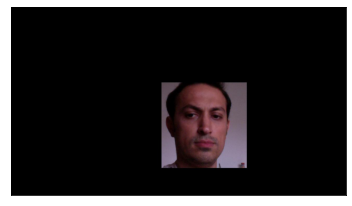

Ground Truth:


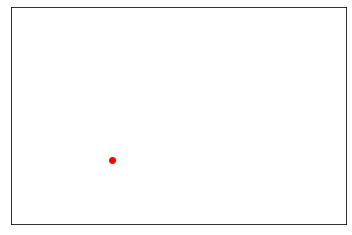

Formula based:


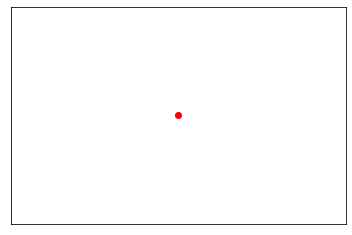

Model based:


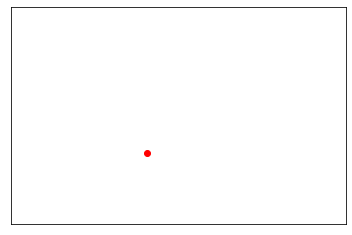

../../_data/MPIIFaceGaze/p06/day08/0359.jpg


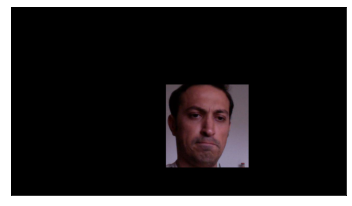

Ground Truth:


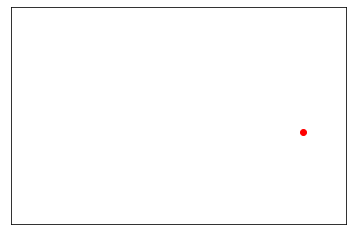

Formula based:


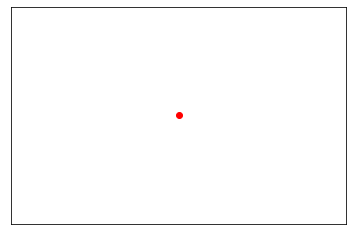

Model based:


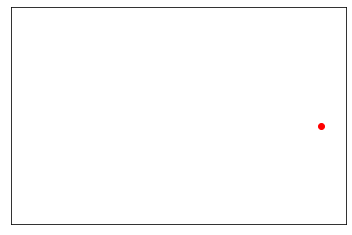

../../_data/MPIIFaceGaze/p06/day09/0005.jpg


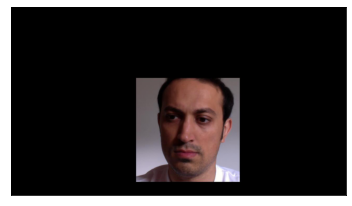

Ground Truth:


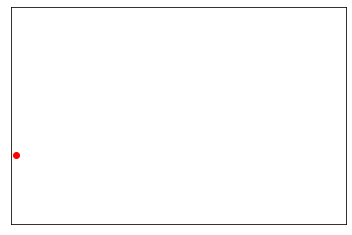

Formula based:


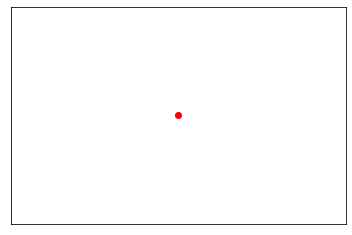

Model based:


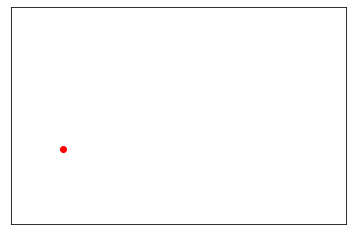

../../_data/MPIIFaceGaze/p13/day05/0404.jpg


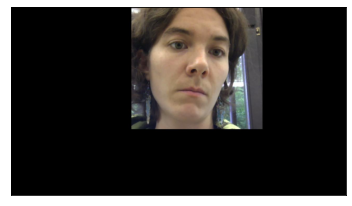

Ground Truth:


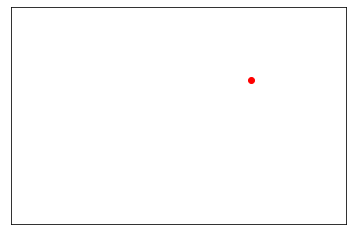

Formula based:


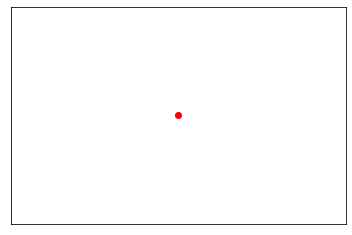

Model based:


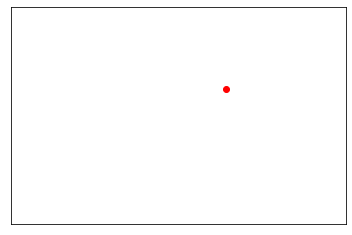

../../_data/MPIIFaceGaze/p13/day05/0405.jpg


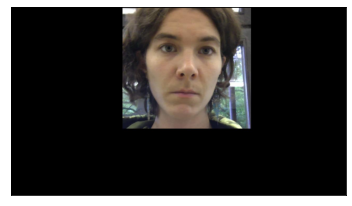

Ground Truth:


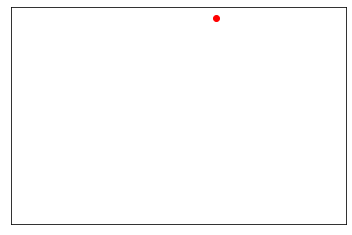

Formula based:


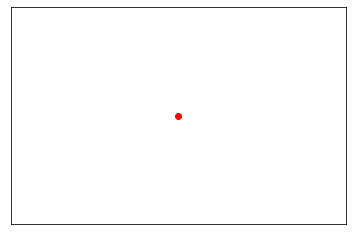

Model based:


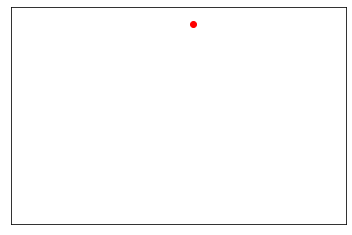

../../_data/MPIIFaceGaze/p13/day05/0406.jpg


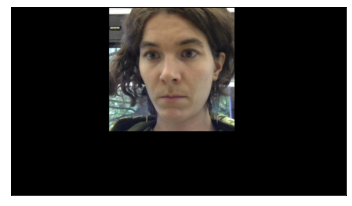

Ground Truth:


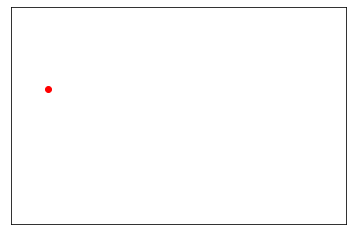

Formula based:


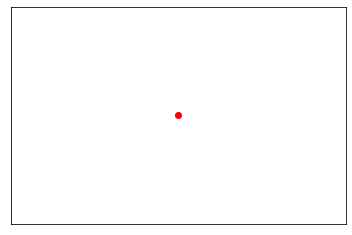

Model based:


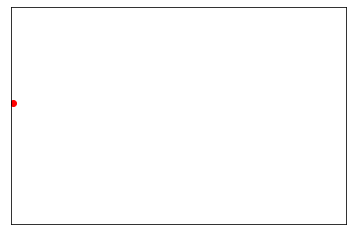

../../_data/MPIIFaceGaze/p04/day05/0011.jpg


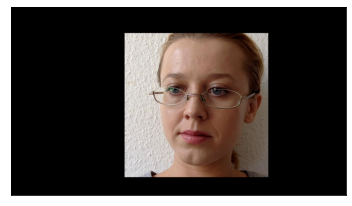

Ground Truth:


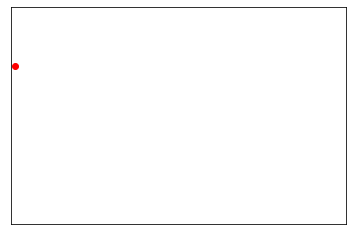

Formula based:


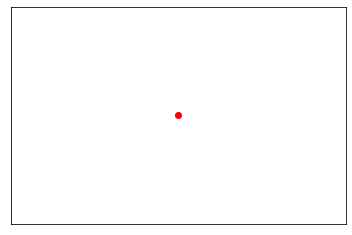

Model based:


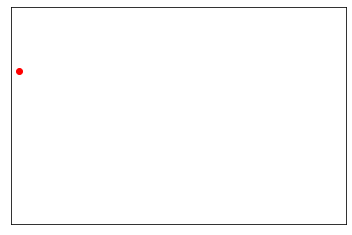

../../_data/MPIIFaceGaze/p04/day05/0015.jpg


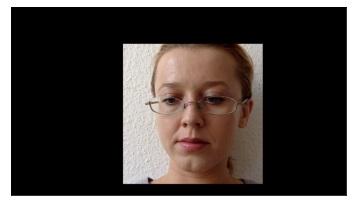

Ground Truth:


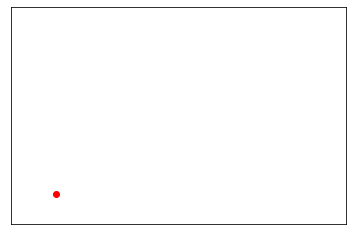

Formula based:


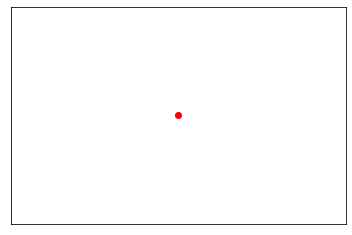

Model based:


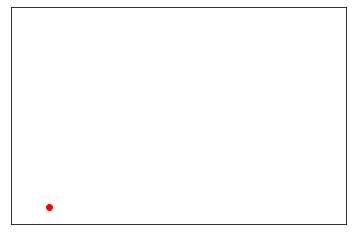

../../_data/MPIIFaceGaze/p04/day05/0016.jpg


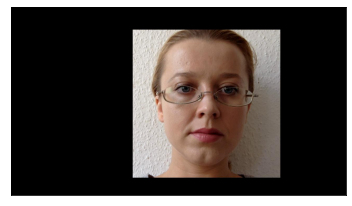

Ground Truth:


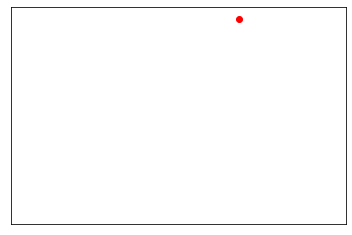

Formula based:


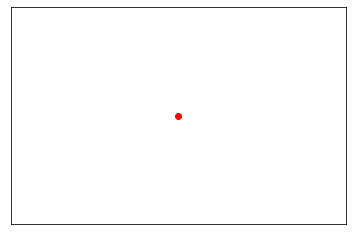

Model based:


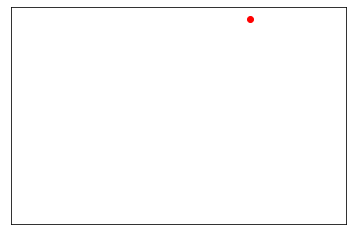

In [160]:
for i in index:
    for j in range(i, i+3):
        path = root + feature[["FilePath"]].iloc[j].values[0]
        p_idx = path.split('/')[4]
        print(path)
        
        img = Image.open(path)
        plt.imshow(np.array(img))
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/" + '_'.join(path.split('/')[-3:]))
        plt.show()
        
        print("Ground Truth:")
        drawOutputPoint(p_idx, groudtruth(j))
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/gt_" + '_'.join(path.split('/')[-3:]))
        plt.show()
        
        print("Formula based:")
        drawOutputPoint(p_idx, formula(v_aov, K, j))
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/formula_" + '_'.join(path.split('/')[-3:]))
        plt.show()
        
        print("Model based:")
        drawOutputPoint(p_idx, modelbased(j))
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/model_" + '_'.join(path.split('/')[-3:]))
        plt.show()

point 합치기

../../_data/MPIIFaceGaze/p04/day05/0011.jpg


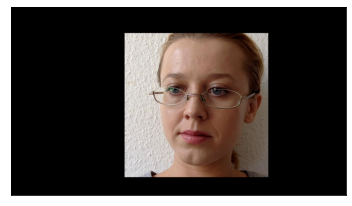

Point:


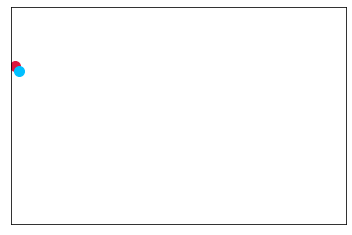

../../_data/MPIIFaceGaze/p04/day05/0015.jpg


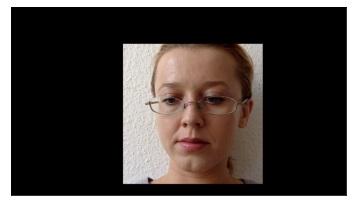

Point:


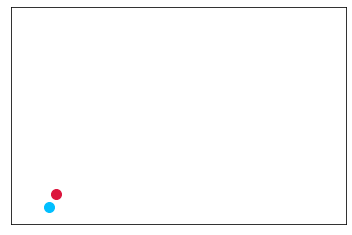

../../_data/MPIIFaceGaze/p04/day05/0016.jpg


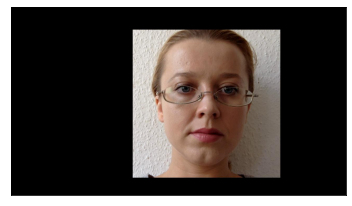

Point:


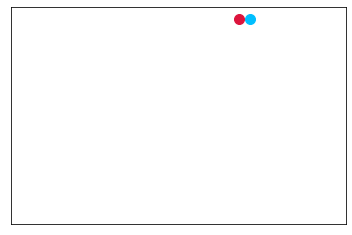

../../_data/MPIIFaceGaze/p03/day45/0288.jpg


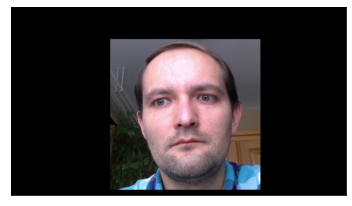

Point:


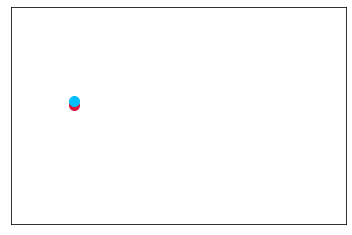

../../_data/MPIIFaceGaze/p03/day45/0301.jpg


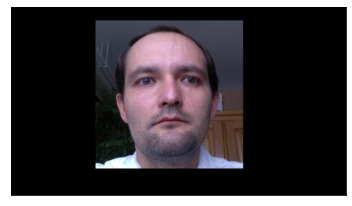

Point:


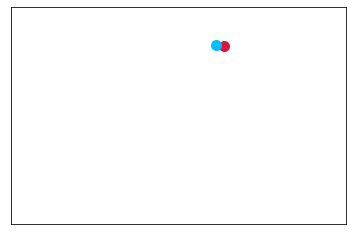

../../_data/MPIIFaceGaze/p03/day45/0305.jpg


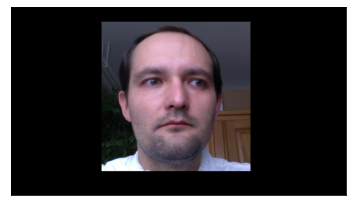

Point:


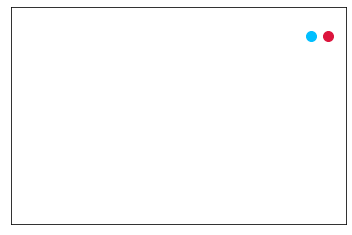

../../_data/MPIIFaceGaze/p14/day04/0092.jpg


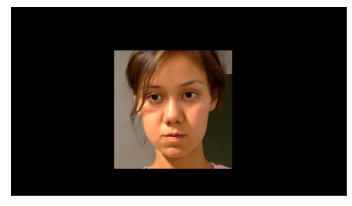

Point:


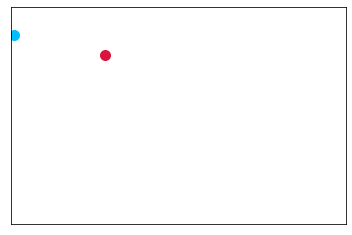

../../_data/MPIIFaceGaze/p14/day04/0093.jpg


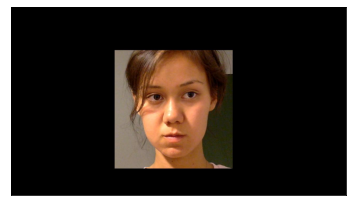

Point:


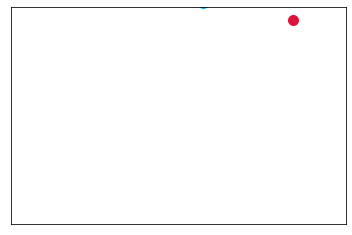

../../_data/MPIIFaceGaze/p14/day04/0094.jpg


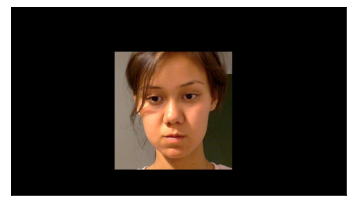

Point:


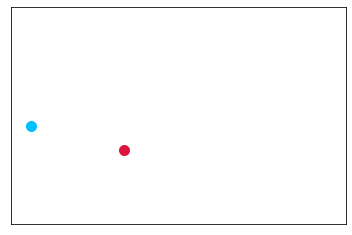

In [36]:
for i in index:
    for j in range(i, i+3):
        path = root + feature[["FilePath"]].iloc[j].values[0]
        p_idx = path.split('/')[4]
        print(path)
        
        img = Image.open(path)
        plt.imshow(np.array(img))
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/" + '_'.join(path.split('/')[-3:]))
        plt.show()
        
        print("Point:")
        drawOutput2Point(p_idx, groudtruth(j), modelbased(j), c1="crimson", c2="deepskyblue", s=100)
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # plt.savefig("C:/Users/dcd/Desktop/cw/PRLab/학회/시선추적/IHCI 2022/그림/point_" + '_'.join(path.split('/')[-3:]))
        plt.show()